In [ ]:
#|default_exp schedulers.fit_flat_varied

# Fit Flat Varied
> Like `fit_flat_cos`, but allows changing to multiple new learning rates immediately or via any fastai schedule.

In [ ]:
#|export
import warnings
import numpy as np
from fastcore.basics import even_mults
from fastcore.foundation import patch, L
from fastai.learner import Learner
from fastai.callback.schedule import SchedCos, SchedNo, combine_scheds, ParamScheduler
from fastxtend.basics import is_listish

In [ ]:
#|export
@patch
def fit_flat_varied(self:Learner, n_epoch, start_lr=None, div_final=1e5, pct_start=0.75, wd=None,
                    next_lr=None, change_by=None, change_time=1, change_sched=None, cbs=None, reset_opt=False):
    """
    Fit `self.model` for `n_epoch` at flat `start_lr`, then change to flat `next_lr` at `change_by`, 
    optionally with cosine annealing or custom `change_sched` over `change_time`. Final cosine annealing at `pct_start`.
    
    `n_epoch`, `start_lr`, `div_final`, `pct_start`, `wd`, `cbs`, & `reset_opt` are all same as fit_flat_cos from fast.ai.

    `next_lr` single or list of learning rates to switch to at change_by. Must be same length as `change_by`.

    `change_by` single or list of epochs or percent of steps to switch to `next_lr` by. Must be same length as `next_lr`.

    `change_time` if greater than 0 (percent of steps or epochs), how long to cosine anneal to `next_lr`. Can be single or list of same length as `next_lr`.

    `change_sched` optional single or list of fast.ai schedules. If `None` defaults to `SchedCos`. Must be same length as `next_lr`. `SchedPoly` must be passed as partial: `partial(SchedPoly, power=0.5)`.
    """
    assert isinstance(next_lr, (float, slice)) or (is_listish(next_lr) and len(next_lr)>=1), '`next_lr` must be float, slice, or list of float or slice'
    assert isinstance(change_by, (int, float, slice)) or (is_listish(change_by) and len(change_by)>=1), '`change_by` must be int, float, slice, or list of int, float, or slice'

    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if start_lr is None else start_lr)
    start_lr = np.array([h['lr'] for h in self.opt.hypers])
    params_len = len(start_lr)

    if not is_listish(next_lr): next_lr = [next_lr]
    if not is_listish(change_by): change_by = [change_by]
    change_by = [i/n_epoch if i>=1 else i for i in change_by]
    assert len(change_by)==len(next_lr), '`next_lr` & `change_by` need to be same length'

    if not is_listish(change_time): change_time = [change_time]*len(change_by)
    else: assert len(change_by)==len(change_time), '`change_time` list needs to be same length as `next_lr` & `change_by`'
    change_time = [i/n_epoch if i>=1 else i for i in change_time]

    if change_sched is not None: 
        if not is_listish(change_sched): change_sched = [change_sched]
        assert len(change_by)==len(change_sched), '`next_lr` & `change_sched` need to be same length'

    pcts, scheds, last_lr, last_pct = [], [SchedNo(start_lr, start_lr)], start_lr, 0
    for i, cb in enumerate(change_by):
        if cb < pct_start:
            nlr = next_lr[i]
            if isinstance(nlr, slice):
                if nlr.start: nlr = even_mults(nlr.start, nlr.stop, params_len)
                else: nlr = [nlr.stop/10]*(params_len-1) + [nlr.stop]
                nlr=np.array(nlr)
            change_pct = cb - change_time[i]
            assert change_pct >= last_pct, f'{change_pct} in pos {i} of `change_by` overlaps with previous schedule {last_pct}'
            pcts.append(change_pct - sum(pcts))
            scheds.append(SchedNo(nlr, nlr))
            if change_time[i] > 0:
                pcts.append(change_time[i])
                if is_listish(change_sched): scheds.insert(-1, change_sched[i](last_lr, nlr))
                else: scheds.insert(-1, SchedCos(last_lr, nlr))
            last_lr = nlr
            last_pct = change_pct
        else: warnings.warn(f'change_by: {change_by[i]} is after pct_start={pct_start} and ignored.')
    pcts += [pct_start - sum(pcts), 1-pct_start]
    scheds += [SchedCos(last_lr, last_lr/div_final)]

    scheds = {'lr': combine_scheds(pcts, scheds)}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

## Example Schedules

Discriminative Linear Warmup:

`learn.fit_flat_varied(4, slice(3e-5, 3e-3), next_lr=3e-3, change_by=1, change_time=1, change_sched=SchedLin)`

![discriminative linear warmup](images/fit_flat_varied_3.png)

Multiple Cosine Annealing:

`learn.fit_flat_varied(15, 8e-3, next_lr=[6e-3, 4e-3], change_by=[4, 8], change_time=2)`

![multiple cosine annealing](images/fit_flat_varied_1.png)


Immediate Change:

`learn.fit_flat_varied(10, 8e-3, next_lr=[6e-3, 4e-3], change_by=[0.25, 0.5], change_time=0)`

![immediate change](images/fit_flat_varied_2.png)

[0, 0.5519981384277344, 0.009125043638050556, '00:00']
[1, 0.0736357569694519, 0.009279237128794193, '00:00']
[2, 0.018577147275209427, 0.009262175299227238, '00:00']
[3, 0.011731836013495922, 0.009302484802901745, '00:00']


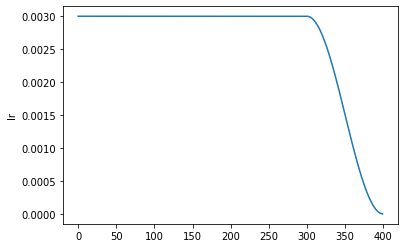

In [ ]:
#|hide
#|slow
from fastai.test_utils import synth_learner
from fastai.callback.schedule import SchedLin

learn = synth_learner(100, 10)
learn.fit_flat_varied(4, slice(3e-5, 3e-3), next_lr=3e-3, change_by=1, change_time=1, change_sched=SchedLin)
learn.recorder.plot_sched()

[0, 0.4857367277145386, 0.010013757273554802, '00:00']
[1, 0.06560628116130829, 0.009947831742465496, '00:00']
[2, 0.017354624345898628, 0.009765828028321266, '00:00']
[3, 0.011333700269460678, 0.010316001251339912, '00:00']
[4, 0.010050332173705101, 0.009690850973129272, '00:00']
[5, 0.01015984546393156, 0.009897427633404732, '00:00']
[6, 0.01005034614354372, 0.00972864218056202, '00:00']
[7, 0.009965868666768074, 0.009740944020450115, '00:00']
[8, 0.01029820367693901, 0.009805220179259777, '00:00']
[9, 0.010123246349394321, 0.009986121207475662, '00:00']
[10, 0.009817359037697315, 0.009939275681972504, '00:00']
[11, 0.009877949953079224, 0.00973101519048214, '00:00']
[12, 0.009876875206828117, 0.009846814908087254, '00:00']
[13, 0.00998685322701931, 0.00983098428696394, '00:00']
[14, 0.009789206087589264, 0.009836437180638313, '00:00']


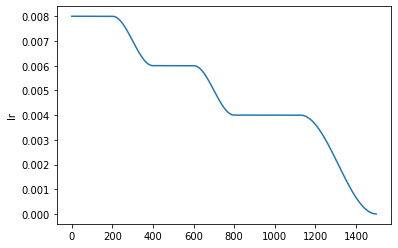

In [ ]:
#|hide
#|slow
learn = synth_learner(100, 10)
learn.fit_flat_varied(15, 8e-3, next_lr=[6e-3, 4e-3], change_by=[4, 8], change_time=2)
learn.recorder.plot_sched()

[0, 0.7806915640830994, 0.010005583986639977, '00:00']
[1, 0.10016239434480667, 0.009833318181335926, '00:00']
[2, 0.021698256954550743, 0.00981915183365345, '00:00']
[3, 0.011349670588970184, 0.009730835445225239, '00:00']
[4, 0.010066516697406769, 0.00972744356840849, '00:00']
[5, 0.009601901285350323, 0.009733257815241814, '00:00']
[6, 0.009675953537225723, 0.009685656055808067, '00:00']
[7, 0.00978333130478859, 0.009677143767476082, '00:00']
[8, 0.00942174345254898, 0.00970753189176321, '00:00']
[9, 0.009458736516535282, 0.009744592010974884, '00:00']


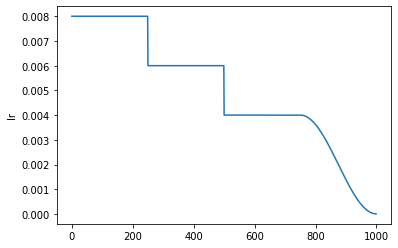

In [ ]:
#|hide
#|slow
learn = synth_learner(100, 10)
learn.fit_flat_varied(10, 8e-3, next_lr=[6e-3, 4e-3], change_by=[0.25, 0.5], change_time=0)
learn.recorder.plot_sched()

In [ ]:
#|hide
#|slow
from nbdev.export import notebook2script; notebook2script()

Converted augment.tensor_item_tfm.ipynb.
Converted index.ipynb.
Converted schedulers.fit_flat_varied.ipynb.
